># Pratica - Segmentação Semântica usando PyTorch
> 
> Deep Learning

Instalação das libs necessárias
* Testado com Python 3.10 e CUDA 11.8
  
> ```bash
> conda create --name deepl python=3.10 --no-default-packages
> conda activate deepl
> ```

> ```bash
> pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
> pip install -r requirements.txt
> ```

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import torchmetrics

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [2]:
# -- PARÂMETROS GLOBAIS --
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Parâmetros do dataset e treinamento
DATA_DIR = "./data"
IMAGE_SIZE = 128
BATCH_SIZE = 16
NUM_CLASSES = 3  # Oxford Pet: 0 (Pet), 1 (Fundo), 2 (Borda)
LEARNING_RATE = 0.001
NUM_EPOCHS = 5

# Dataset reduzido para treino
NUM_TRAIN_SAMPLES = 800
NUM_VAL_SAMPLES = 200

print(f"Device: {DEVICE}")

Device: cuda


# PARTE 1: INTRODUÇÃO E TREINAMENTO DE UM SEGMENTADOR

In [3]:
# Transforms nas imagens
image_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Transforms nas masks
target_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),
])

def process_target(target):
    target = torch.squeeze(target)
    # Valores originais usam 1-index 
    # CrossEntropyLoss usa 0-index
    target = target - 1
    return target.long()

# Carregando o dataset
full_dataset = datasets.OxfordIIITPet(
    root=DATA_DIR,
    split="trainval",
    target_types="segmentation",
    download=True,
    transform=image_transform,
    target_transform=lambda t: process_target(target_transform(t))
)

# Subsets reduzidos para treino e validação por index
indices = torch.randperm(len(full_dataset)).tolist()
train_dataset = Subset(full_dataset, indices[:NUM_TRAIN_SAMPLES])
val_dataset = Subset(full_dataset, indices[NUM_TRAIN_SAMPLES:NUM_TRAIN_SAMPLES + NUM_VAL_SAMPLES])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total: {len(train_dataset)} imagens de treino e {len(val_dataset)} de validação.")

100%|██████████| 792M/792M [06:29<00:00, 2.03MB/s]  
100%|██████████| 19.2M/19.2M [00:17<00:00, 1.07MB/s]


Total: 800 imagens de treino e 200 de validação.


In [4]:
# Bloco de convolução duplo, base da U-Net
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class SimpleUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=NUM_CLASSES, features=[64, 128]):
        super(SimpleUNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Decoder
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature * 2, feature))

        # Bottleneck e final
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Decoder
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.to(DEVICE)
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        model.train()
        running_loss = 0.0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            optimizer.zero_grad()

            outputs = model(images)
            if isinstance(outputs, dict): # FCN() -> dict
                outputs = outputs['out']
            
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                images = images.to(DEVICE)
                masks = masks.to(DEVICE)
                
                outputs = model(images)
                if isinstance(outputs, dict):
                    outputs = outputs['out']

                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        
        end_time = time.time()
        epoch_duration = end_time - start_time
        
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Duração: {epoch_duration:.2f}s - "
              f"Train Loss: {epoch_loss:.4f} - "
              f"Val Loss: {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f"{model.__class__.__name__}_best.pth")
            print(f"  -> Modelo salvo com a melhor val loss: {best_loss:.4f}")
            
    return model

In [6]:

# ------------ UNet
print("Training : U-Net")
unet_model = SimpleUNet(in_channels=3, out_channels=NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet_model.parameters(), lr=LEARNING_RATE)

trained_unet = train_model(unet_model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS)

print("\n" + "="*50 + "\n")

# ------------ FCN-ResNet50
print("Training : FCN-ResNet50")
fcn_model = models.segmentation.fcn_resnet50(weights=models.segmentation.FCN_ResNet50_Weights.DEFAULT)
# original: varias classes
# nosso dataset: 3 classes
fcn_model.classifier[4] = nn.Conv2d(512, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fcn_model.parameters(), lr=LEARNING_RATE)

trained_fcn = train_model(fcn_model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS)

Training : U-Net


Epoch 1/5 [Val]: 100%|██████████| 13/13 [00:03<00:00,  3.46it/s]


Epoch 1/5 - Duração: 22.58s - Train Loss: 0.7971 - Val Loss: 0.6960
  -> Modelo salvo com a melhor val loss: 0.6960


Epoch 2/5 [Val]: 100%|██████████| 13/13 [00:01<00:00, 11.96it/s]


Epoch 2/5 - Duração: 9.05s - Train Loss: 0.6869 - Val Loss: 0.6364
  -> Modelo salvo com a melhor val loss: 0.6364


Epoch 3/5 [Val]: 100%|██████████| 13/13 [00:01<00:00, 11.43it/s]


Epoch 3/5 - Duração: 8.96s - Train Loss: 0.6426 - Val Loss: 0.8285


Epoch 4/5 [Val]: 100%|██████████| 13/13 [00:01<00:00, 11.77it/s]


Epoch 4/5 - Duração: 8.99s - Train Loss: 0.6189 - Val Loss: 0.5950
  -> Modelo salvo com a melhor val loss: 0.5950


Epoch 5/5 [Val]: 100%|██████████| 13/13 [00:01<00:00, 12.31it/s]


Epoch 5/5 - Duração: 9.04s - Train Loss: 0.5962 - Val Loss: 0.5774
  -> Modelo salvo com a melhor val loss: 0.5774


Training : FCN-ResNet50


Epoch 1/5 [Val]: 100%|██████████| 13/13 [00:01<00:00, 10.23it/s]


Epoch 1/5 - Duração: 10.37s - Train Loss: 0.5310 - Val Loss: 0.4580
  -> Modelo salvo com a melhor val loss: 0.4580


Epoch 2/5 [Val]: 100%|██████████| 13/13 [00:01<00:00, 10.38it/s]


Epoch 2/5 - Duração: 10.33s - Train Loss: 0.3827 - Val Loss: 0.4575
  -> Modelo salvo com a melhor val loss: 0.4575


Epoch 3/5 [Val]: 100%|██████████| 13/13 [00:01<00:00, 10.74it/s]


Epoch 3/5 - Duração: 10.35s - Train Loss: 0.3494 - Val Loss: 0.3843
  -> Modelo salvo com a melhor val loss: 0.3843


Epoch 4/5 [Val]: 100%|██████████| 13/13 [00:01<00:00, 10.35it/s]


Epoch 4/5 - Duração: 10.38s - Train Loss: 0.3172 - Val Loss: 0.3947


Epoch 5/5 [Val]: 100%|██████████| 13/13 [00:01<00:00, 10.28it/s]

Epoch 5/5 - Duração: 10.36s - Train Loss: 0.2884 - Val Loss: 0.3861


# PARTE 2 - AVALIAÇÃO E MÉTRICAS

In [7]:
def calculate_iou_manual(preds, targets, num_classes):
    preds = torch.argmax(preds, dim=1)
    
    preds = preds.view(-1)
    targets = targets.view(-1)
    
    iou_per_class = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (targets == cls)
        
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        
        if union == 0:
            iou = 1.0
        else:
            iou = intersection / union
            
        iou_per_class.append(iou)
        
    return np.mean(iou_per_class)

def evaluate_minibatch(model, loader):
    model.eval()
    model.to(DEVICE)
    
    # usando torchmetrics
    # jaccard: IoU
    jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=NUM_CLASSES, average='macro').to(DEVICE)
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES, average='macro').to(DEVICE)
    
    with torch.no_grad():
        # um batch de validation
        images, masks = next(iter(loader))
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        
        outputs = model(images)
        if isinstance(outputs, dict):
            outputs = outputs['out']
            
        # metrica
        iou_manual = calculate_iou_manual(outputs, masks, NUM_CLASSES)
        
        # metricas com torchmetrics
        tm_iou = jaccard(outputs, masks)
        tm_acc = accuracy(outputs, masks)
        
        print(f"--- Avaliação de um Minibatch para '{model.__class__.__name__}' ---")
        print(f"IoU (medio) calculado manualmente: {iou_manual:.4f}")
        print(f"IoU (medio) com Torchmetrics:     {tm_iou.item():.4f}")
        print(f"Acurácia (media) com Torchmetrics: {tm_acc.item():.4f}\n")

evaluate_minibatch(trained_unet, val_loader)
evaluate_minibatch(trained_fcn, val_loader)

--- Avaliação de um Minibatch para 'SimpleUNet' ---
IoU (medio) calculado manualmente: 0.4826
IoU (medio) com Torchmetrics:     0.4826
Acurácia (media) com Torchmetrics: 0.6077

--- Avaliação de um Minibatch para 'FCN' ---
IoU (medio) calculado manualmente: 0.6661
IoU (medio) com Torchmetrics:     0.6661
Acurácia (media) com Torchmetrics: 0.7766



# PARTE 3 - VISUALIZAÇÃO DOS RESULTADOS

In [8]:
# Utils para visualização

def unnormalize_image(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def mask_to_rgb(mask, num_classes=NUM_CLASSES):
    colors = torch.tensor([
        [255, 0, 0],    # 0 (Pet) = Red
        [0, 255, 0],    # 1 (Fundo) = Green
        [0, 0, 255]     # 2 (Borda) = Blue
    ], dtype=torch.uint8)
    
    rgb_mask = torch.zeros(mask.size(0), mask.size(1), 3, dtype=torch.uint8)
    for cls in range(num_classes):
        rgb_mask[mask == cls] = colors[cls]
        
    return rgb_mask.numpy()


def visualize_predictions(model, loader, num_images=5):
    model.eval()
    model.to(DEVICE)
    
    images, masks = next(iter(loader))
    images, masks = images.to(DEVICE), masks.to(DEVICE)

    with torch.no_grad():
        outputs = model(images)
        if isinstance(outputs, dict):
            outputs = outputs['out']
        preds = torch.argmax(outputs, dim=1)

    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()

    plt.figure(figsize=(15, num_images * 5))
    plt.suptitle(f"Resultados para {model.__class__.__name__}", fontsize=16)

    for i in range(num_images):
        # Original
        ax = plt.subplot(num_images, 3, i * 3 + 1)
        img = unnormalize_image(images[i])
        plt.imshow(img.permute(1, 2, 0))
        ax.set_title("Imagem Original")
        ax.axis("off")
        
        # Mask Ground Truth
        ax = plt.subplot(num_images, 3, i * 3 + 2)
        gt_mask_rgb = mask_to_rgb(masks[i])
        plt.imshow(gt_mask_rgb)
        ax.set_title("Máscara Real (GT)")
        ax.axis("off")

        # Mask preds
        ax = plt.subplot(num_images, 3, i * 3 + 3)
        pred_mask_rgb = mask_to_rgb(preds[i])
        plt.imshow(pred_mask_rgb)
        ax.set_title("Predição do Modelo")
        ax.axis("off")
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def compare_models(model1, model2, loader, num_images=5):
    model1.eval().to(DEVICE)
    model2.eval().to(DEVICE)
    
    images, masks = next(iter(loader))
    images, masks = images.to(DEVICE), masks.to(DEVICE)

    with torch.no_grad():
        # UNet
        out1 = model1(images)
        if isinstance(out1, dict): out1 = out1['out']
        preds1 = torch.argmax(out1, dim=1)
        
        # FCN
        out2 = model2(images)
        if isinstance(out2, dict): out2 = out2['out']
        preds2 = torch.argmax(out2, dim=1)

    images, masks, preds1, preds2 = images.cpu(), masks.cpu(), preds1.cpu(), preds2.cpu()

    plt.figure(figsize=(20, num_images * 5))
    plt.suptitle("Comparação de Modelos: U-Net vs FCN-ResNet50", fontsize=16)

    for i in range(num_images):
        # Original
        ax = plt.subplot(num_images, 4, i * 4 + 1)
        plt.imshow(unnormalize_image(images[i]).permute(1, 2, 0))
        ax.set_title("Original")
        ax.axis("off")

        # Ground Truth
        ax = plt.subplot(num_images, 4, i * 4 + 2)
        plt.imshow(mask_to_rgb(masks[i]))
        ax.set_title("Ground Truth")
        ax.axis("off")

        # Pred UNet
        ax = plt.subplot(num_images, 4, i * 4 + 3)
        plt.imshow(mask_to_rgb(preds1[i]))
        ax.set_title("Pred UNet")
        ax.axis("off")

        # Predição FCN
        ax = plt.subplot(num_images, 4, i * 4 + 4)
        plt.imshow(mask_to_rgb(preds2[i]))
        ax.set_title("Pred FCN")
        ax.axis("off")
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

--- Visualizando Preds da U-Net ---


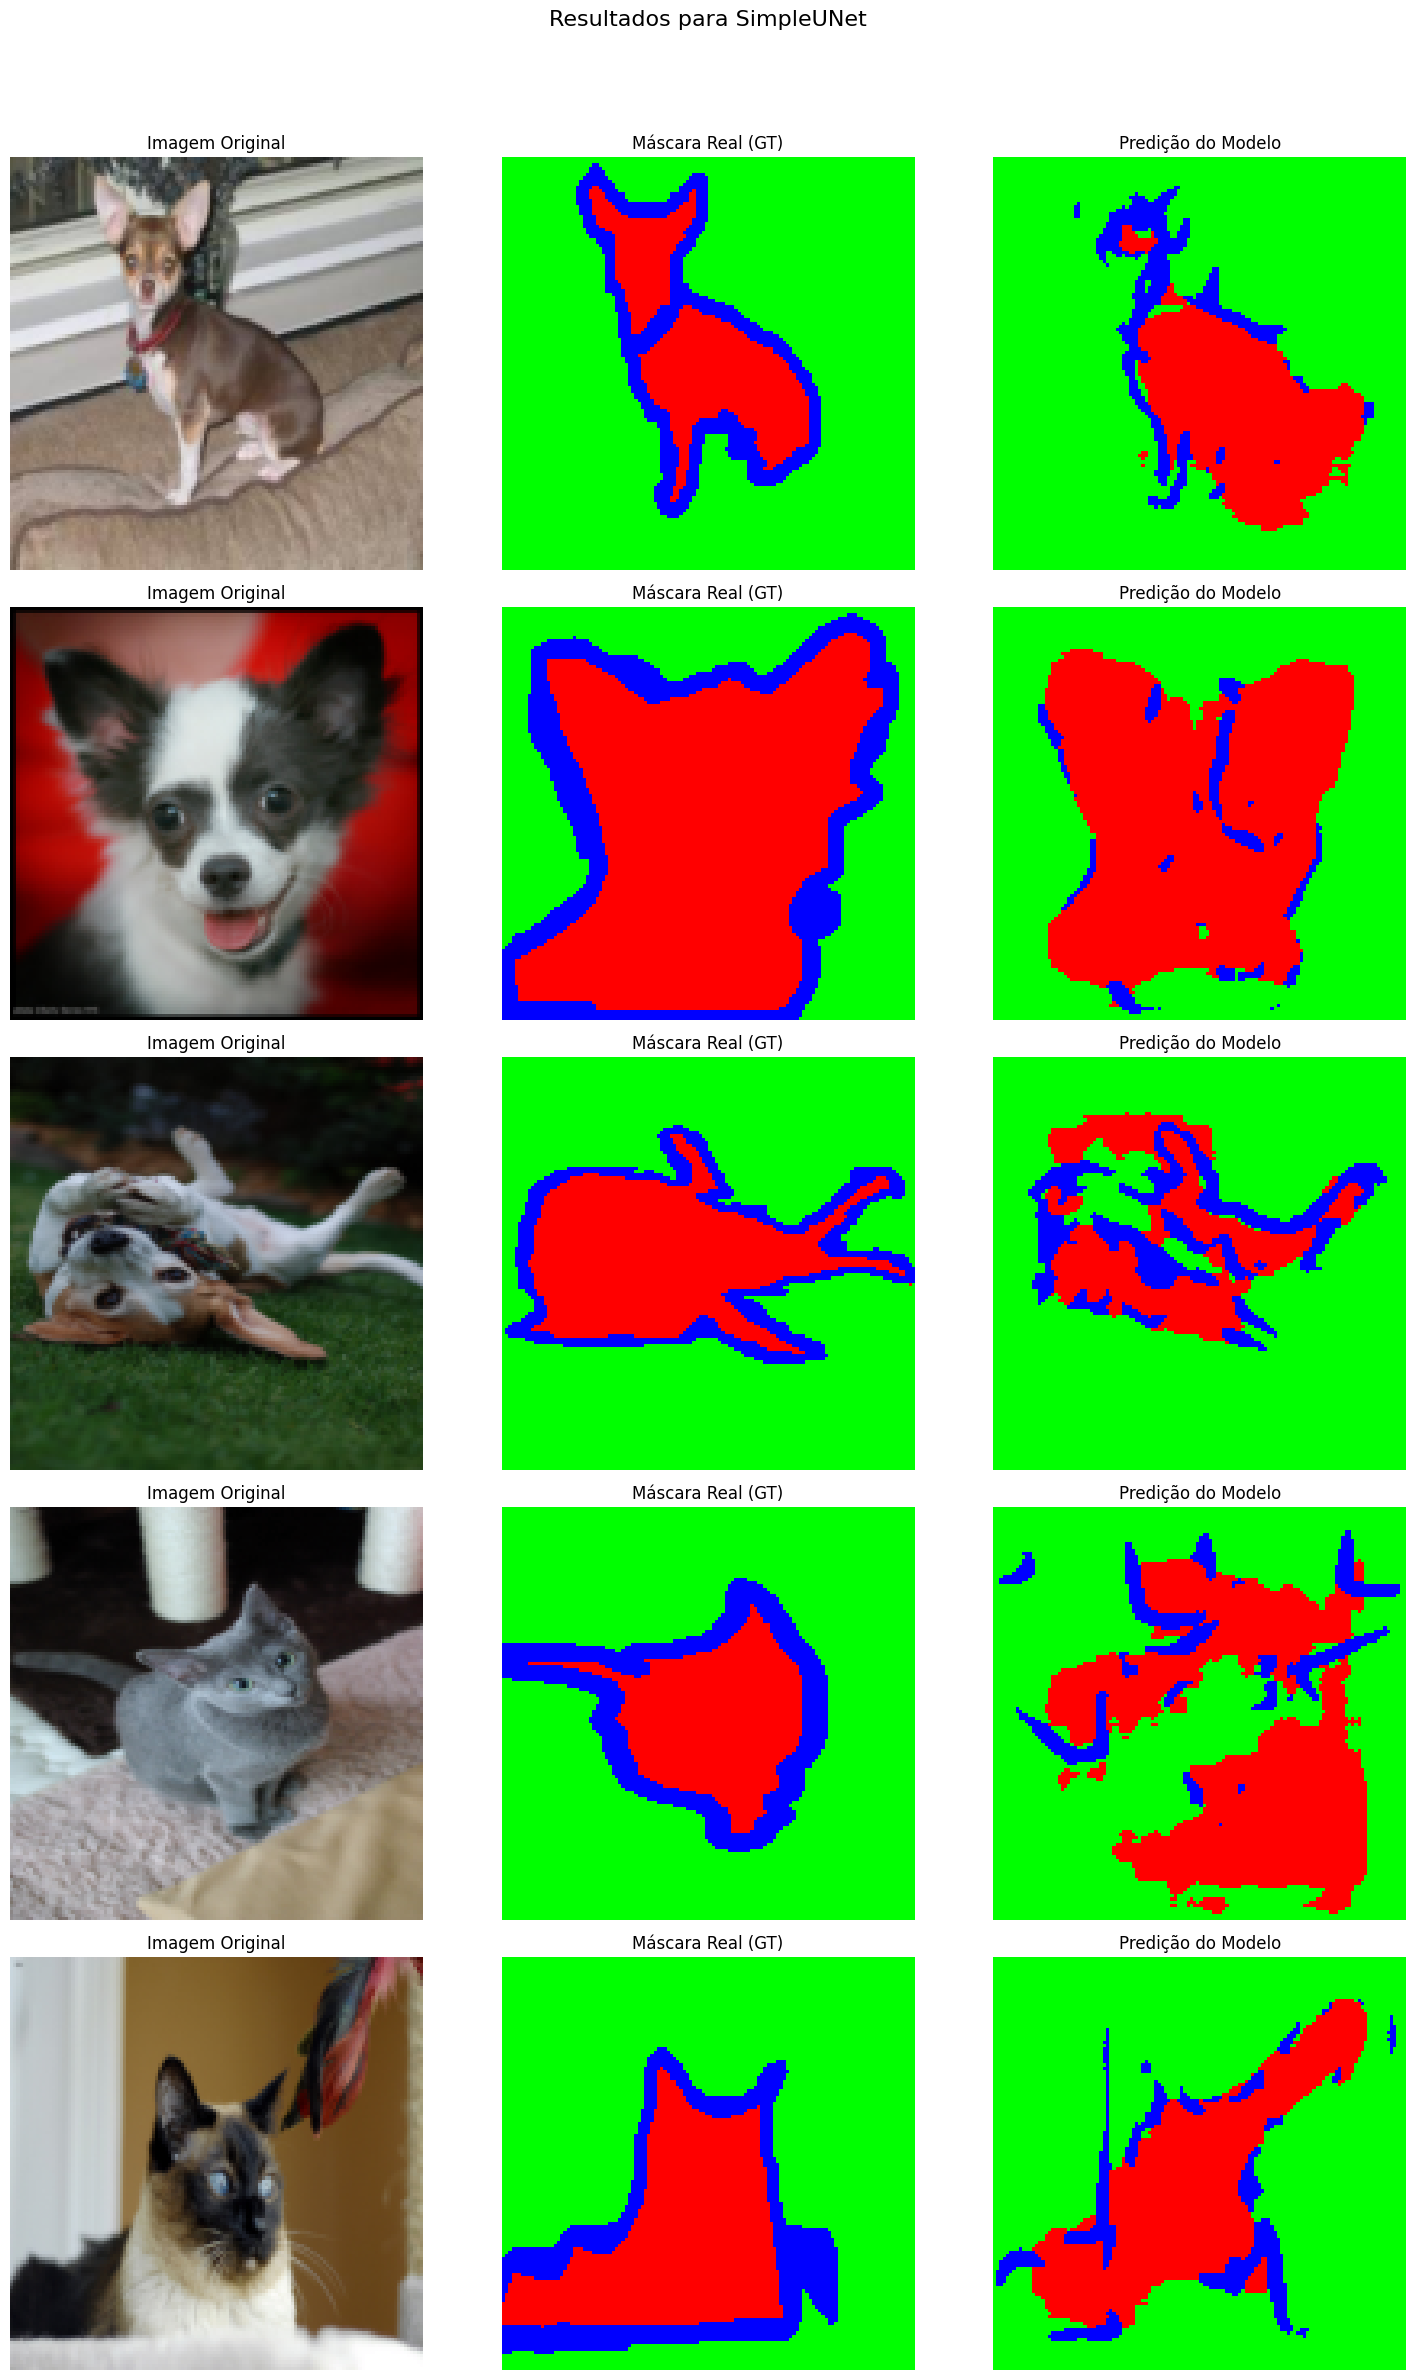


--- Visualizando Preds da FCN-ResNet50 ---


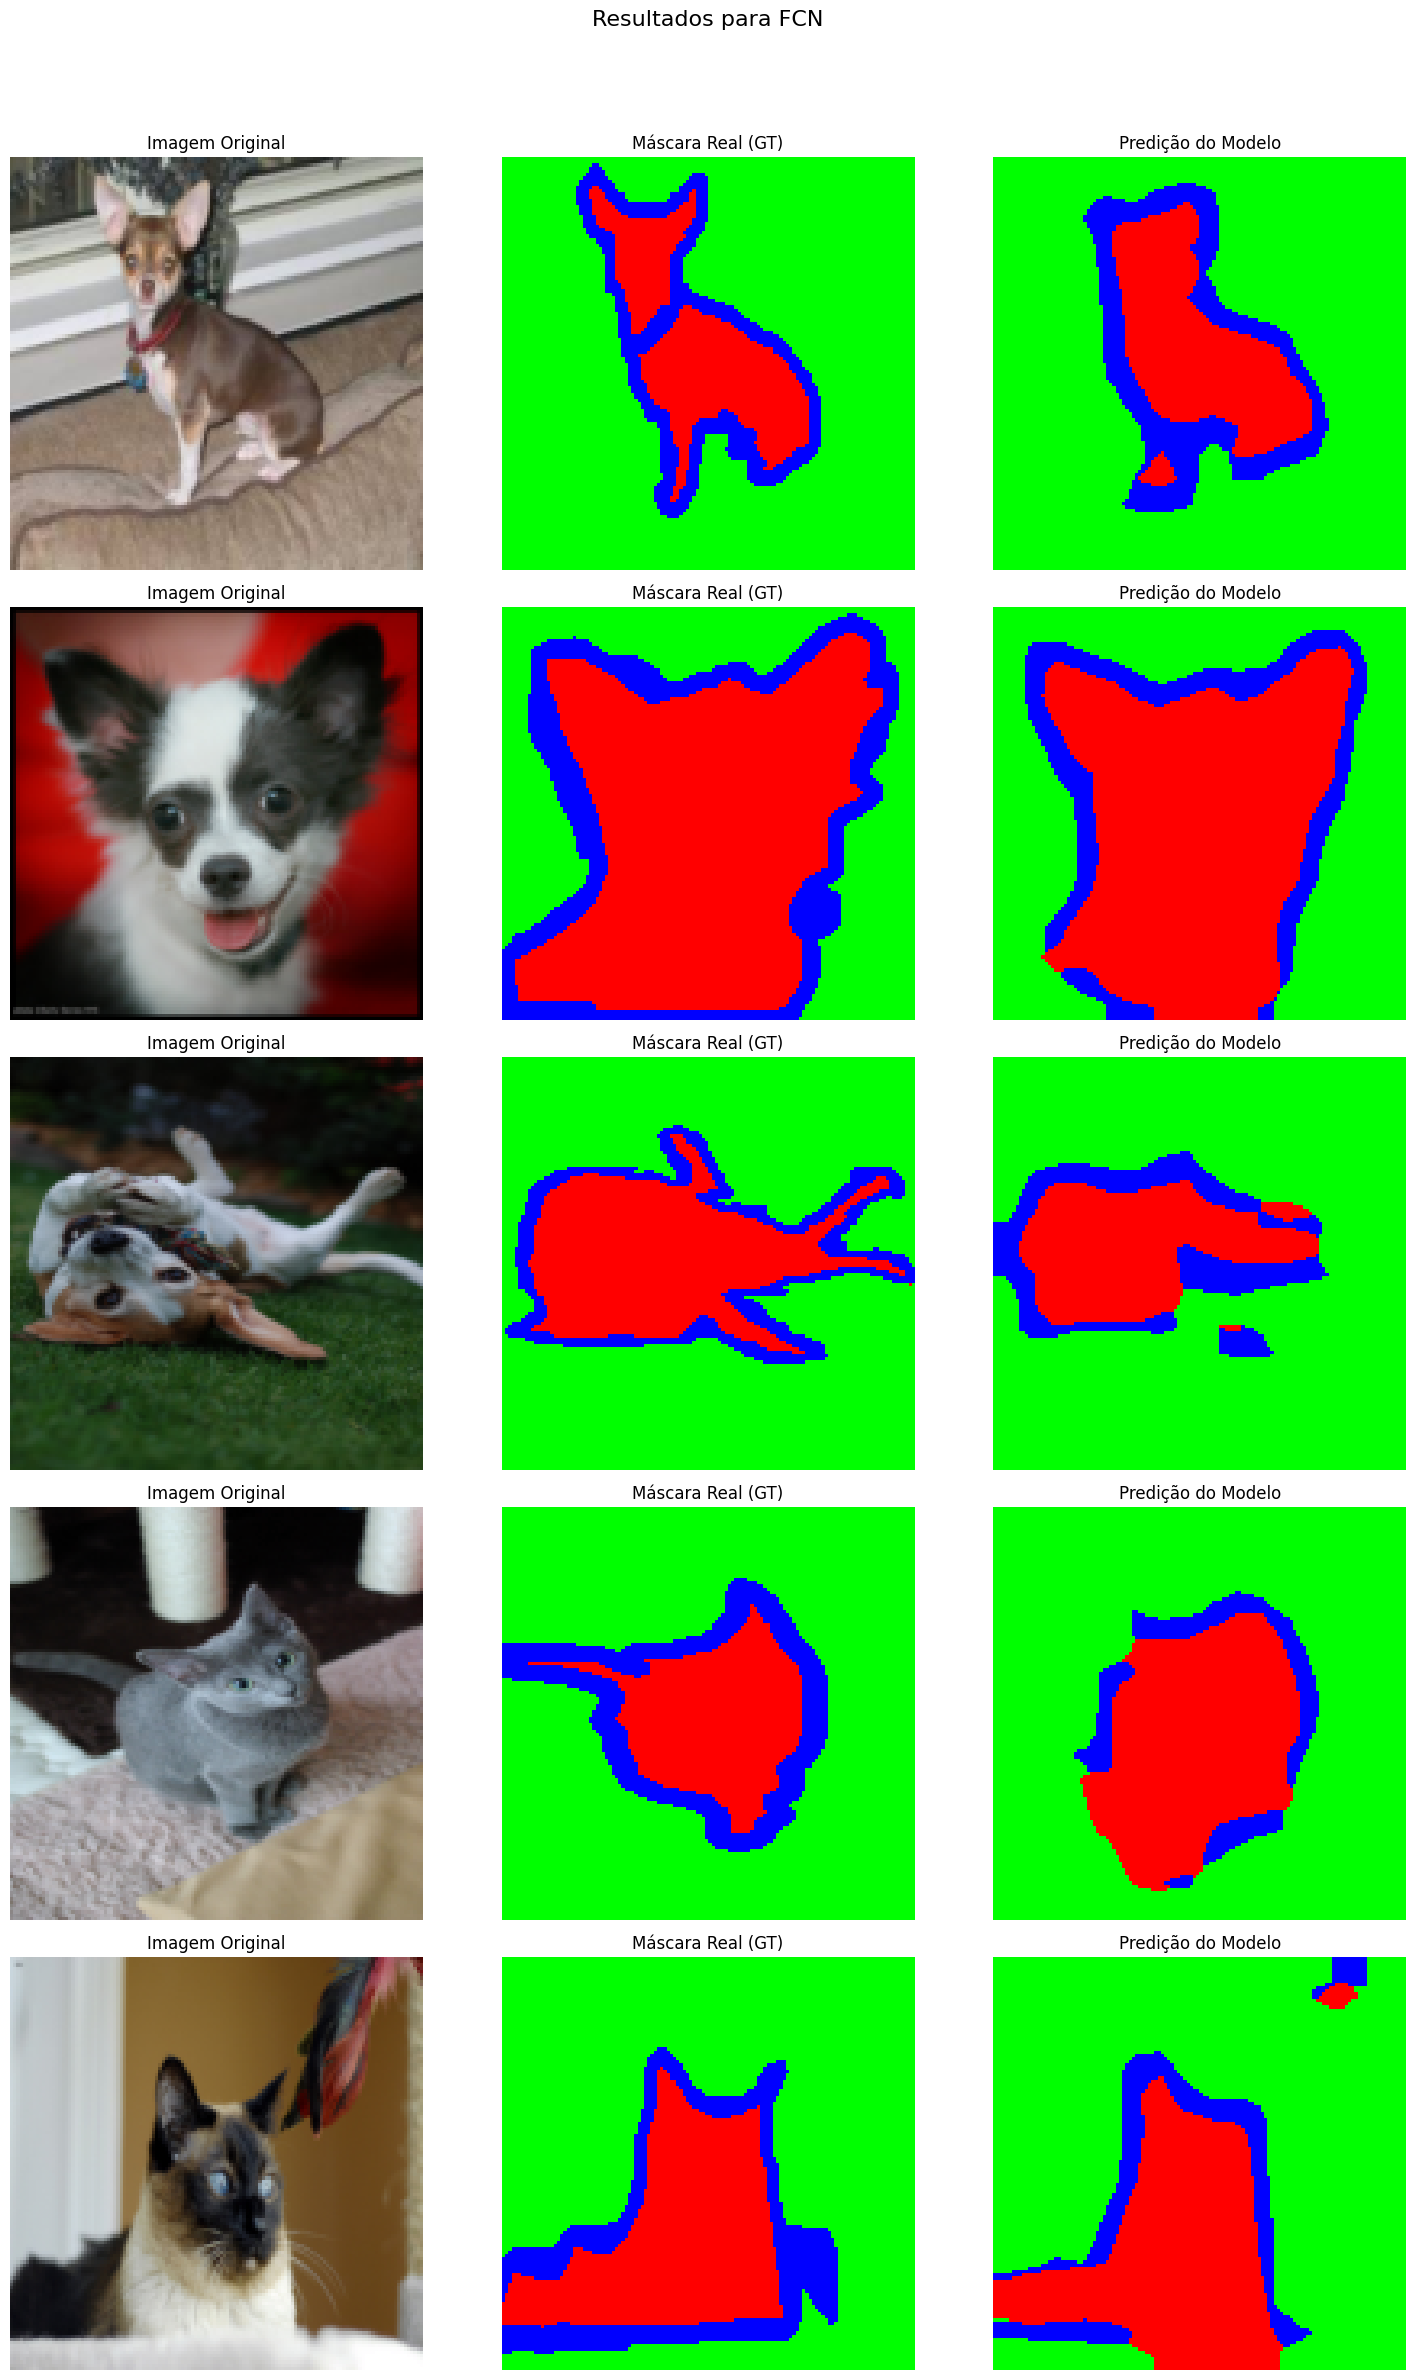


--- Comparando Modelos Lado a Lado ---


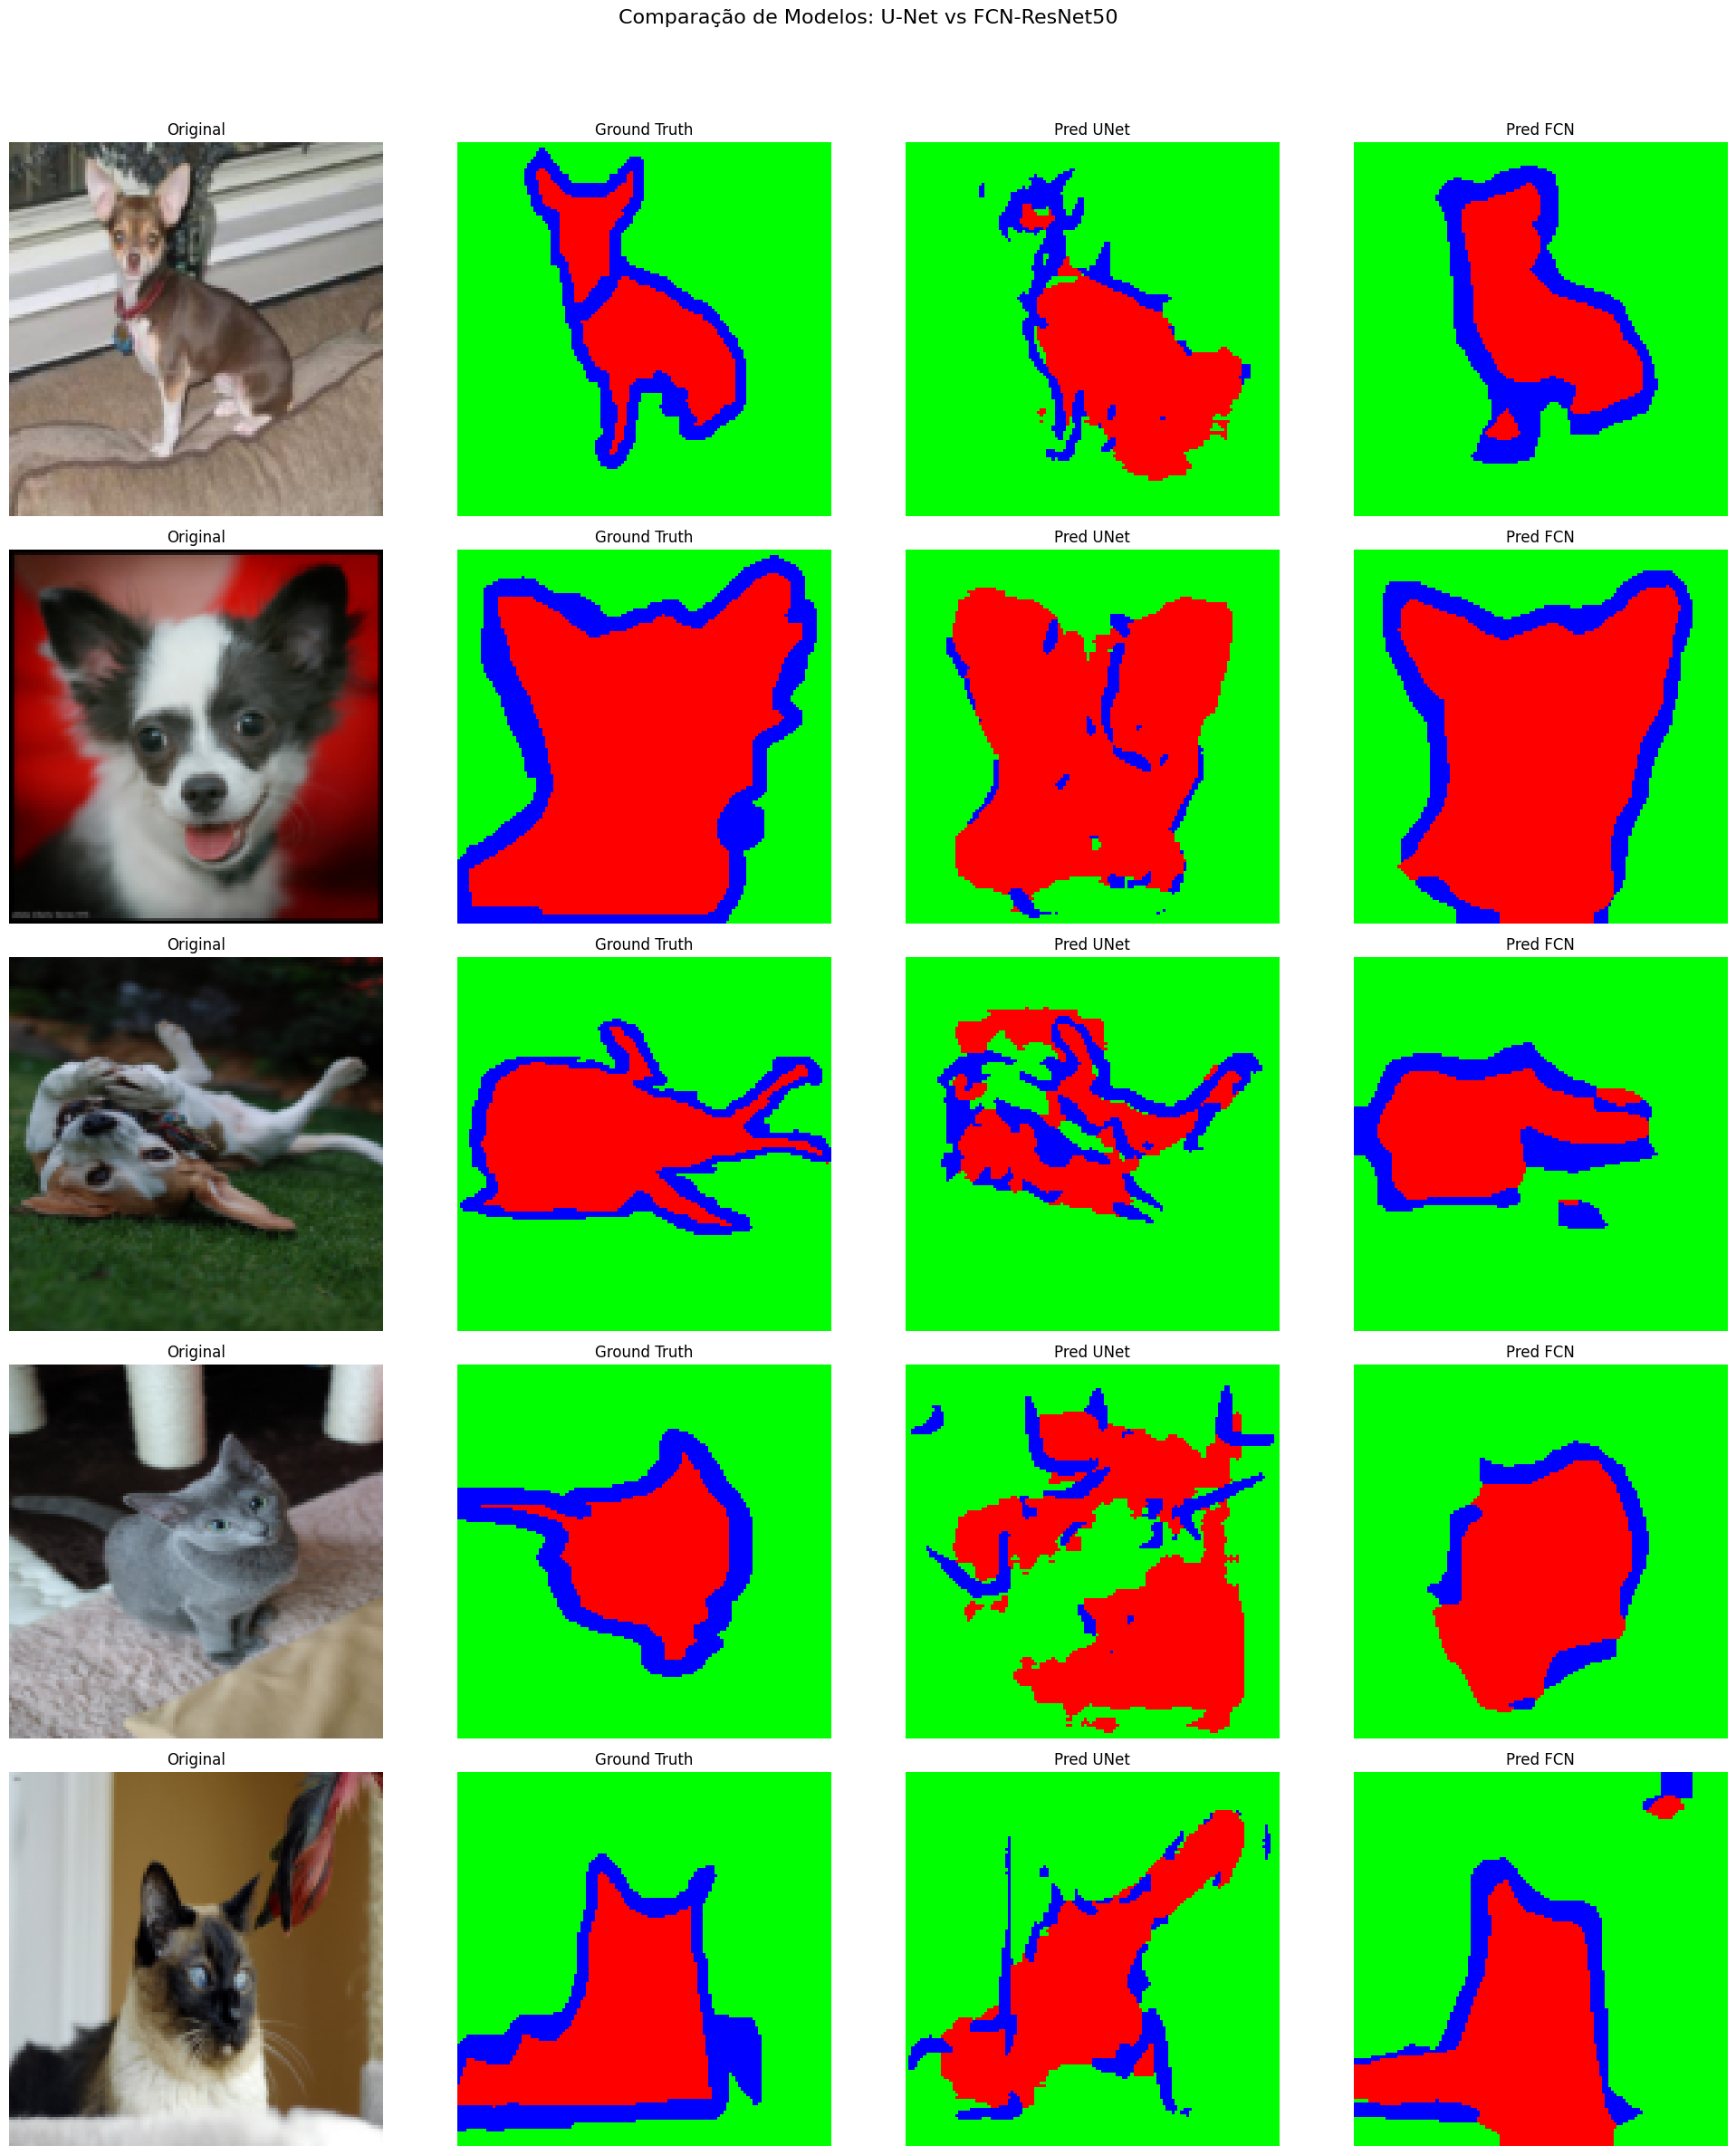

In [9]:
# Carregando os melhores pesos salvos durante o treino para garantir a melhor visualização
trained_unet.load_state_dict(torch.load("SimpleUNet_best.pth"))
trained_fcn.load_state_dict(torch.load("FCN_best.pth"))

# Visualizando os resultados da U-Net
print("--- Visualizando Preds da U-Net ---")
visualize_predictions(trained_unet, val_loader)

# Visualizando os resultados da FCN
print("\n--- Visualizando Preds da FCN-ResNet50 ---")
visualize_predictions(trained_fcn, val_loader)

# Comparando os modelos
print("\n--- Comparando Modelos Lado a Lado ---")
compare_models(trained_unet, trained_fcn, val_loader)